## Predict what color a card is based on it's text in Magic the Gathering

# Install Wizards of the Coast's API wrapper for python

In [ ]:
!pip install mtgsdk

# Import nessesary tools

In [1]:
import numpy as np
import pandas as pd
from mtgsdk import Card
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import pickle as pkl

# Collect Data

In [2]:
def collect_magic_set(mtg_set_code="###"):
    cards = Card.where(set=mtg_set_code).all()
    return cards

def get_text(magic_set):
    """Uses Wizards API to build a dictionary of cards for one "magic_set": name, text, and colors"""
    whole_set = []
    for card in magic_set:
        cards = {
            'text' : card.text,
            'colors' : card.colors,
        }
        
        whole_set.append(cards)
    return whole_set

def get_df(mtg_set_alias):
    magic_set = collect_magic_set(mtg_set_alias)
    magic_set_json = get_text(magic_set)
    magic_set_df = pd.DataFrame(magic_set_json)
    return magic_set_df

def prep_df(magic_set_df):
    magic_set_df = magic_set_df.replace('\n',' ', regex=True)
    magic_set_df['colors'] = magic_set_df['colors'].apply(lambda x : str(x))
    mask = magic_set_df.applymap(lambda x: x is None)
    cols = magic_set_df.columns[(mask).any()]
    magic_set_df = magic_set_df.replace('[]', "['Colorless']")
    for col in magic_set_df[cols]:
        magic_set_df.loc[mask[col], col] = ''
    return magic_set_df

# Load the data

In [8]:
m10_df = get_df('m10')
m13_df = get_df('m13')
m15_df = get_df('m15')
m20_df = get_df('m20')

# Clean data

In [9]:
prep_df(m10_df)
prep_df(m13_df)
prep_df(m15_df)
prep_df(m20_df)

,colors,text
0,['Red'],Gain control of target creature until end of t...
1,['White'],Destroy target tapped creature. You gain 1 lif...
2,['Blue'],Choose target spell or permanent that's red or...
3,['Blue'],When Agent of Treachery enters the battlefield...
4,['Black'],Agonizing Syphon deals 3 damage to any target ...
5,['Blue'],Flying (This creature can't be blocked except ...
6,['White'],+2: You gain 2 life. Put two +1/+1 counters on...
7,['White'],+1: You gain life equal to the number of creat...
8,['White'],"When Ancestral Blade enters the battlefield, c..."
9,['White'],"Flying If you would gain life, you gain that m..."


In [10]:
four_mtg_df = pd.concat([m10_df, m13_df, m15_df, m20_df], ignore_index=True)

In [13]:
four_mtg_df.count()

colors    1087
text      1087
dtype: int64

In [12]:
# replace None's with empty strings for Vectorizing purposes
mask = four_mtg_df.applymap(lambda x: x is None)
cols = four_mtg_df.columns[(mask).any()]
for col in four_mtg_df[cols]:
    four_mtg_df.loc[mask[col], col] = ''
four_mtg_df

,colors,text
0,[Green],Deathtouch (Any amount of damage this deals to...
1,[Black],"{1}{B}, {T}: Target player loses 1 life."
2,[Red],Gain control of target creature until end of t...
3,[Blue],Flying (This creature can't be blocked except ...
4,[White],+1: You gain 2 life.\n−1: Put a +1/+1 counter ...
5,[Blue],{T}: Target creature an opponent controls atta...
6,[],"Whenever a player casts a white spell, you may..."
7,[White],You gain 7 life.
8,[Green],{1}{G}: Create a 1/1 green Insect creature token.
9,[White],Enchant creature\nEnchanted creature gets +1/+...


In [14]:
prep_df(four_mtg_df)

,colors,text
0,['Green'],Deathtouch (Any amount of damage this deals to...
1,['Black'],"{1}{B}, {T}: Target player loses 1 life."
2,['Red'],Gain control of target creature until end of t...
3,['Blue'],Flying (This creature can't be blocked except ...
4,['White'],+1: You gain 2 life. −1: Put a +1/+1 counter o...
5,['Blue'],{T}: Target creature an opponent controls atta...
6,['Colorless'],"Whenever a player casts a white spell, you may..."
7,['White'],You gain 7 life.
8,['Green'],{1}{G}: Create a 1/1 green Insect creature token.
9,['White'],Enchant creature Enchanted creature gets +1/+1...


In [17]:
four_mtg_df = four_mtg_df.replace('[]', "['Colorless']")

In [15]:
four_mtg_df['colors'] = four_mtg_df['colors'].apply(lambda x : str(x))

In [18]:
four_mtg_df['colors'].unique()

array(["['Green']", "['Black']", "['Red']", "['Blue']", "['White']",
       "['Colorless']", "['Black', 'Red', 'Blue']", "['Black', 'Green']",
       "['Black', 'Green', 'Red', 'Blue', 'White']", "['Black', 'White']",
       "['Green', 'Red']", "['Blue', 'White']", "['Green', 'White']",
       "['Black', 'Red', 'White']", "['Black', 'Green', 'White']",
       "['Red', 'Blue', 'White']", "['Red', 'Blue']", "['Black', 'Red']",
       "['Green', 'Red', 'Blue']", "['Green', 'Red', 'White']",
       "['Green', 'Blue']", "['Red', 'White']", "['Black', 'Blue']",
       "['Black', 'Green', 'Blue']"], dtype=object)

In [35]:
to_drop =  ["['Black', 'Red', 'Blue']", 
            "['Black', 'Green']",
            "['Black', 'Green', 'Red', 'Blue', 'White']", 
            "['Black', 'White']",
            "['Green', 'Red']", 
            "['Blue', 'White']", 
            "['Green', 'White']",
            "['Black', 'Red', 'White']", 
            "['Black', 'Green', 'White']",
            "['Red', 'Blue', 'White']", 
            "['Red', 'Blue']", 
            "['Black', 'Red']",
            "['Green', 'Red', 'Blue']", 
            "['Green', 'Red', 'White']",
            "['Green', 'Blue']", 
            "['Red', 'White']", 
            "['Black', 'Blue']",
            "['Black', 'Green', 'Blue']"]

In [38]:
four_mtg_df = four_mtg_df[~four_mtg_df['colors'].isin(to_drop)]

# Train Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(four_mtg_df[['text']], 
                                                    four_mtg_df['colors'],
                                                    test_size=0.2, 
                                                    random_state=2019)

# Tfidf Vectorization in order to model the data

In [489]:
# Tfidf Vectorizing
v = TfidfVectorizer(max_df= .5)

x_train_tfidf = v.fit_transform(X_train['text'])

In [325]:
idf = v.idf_
feat_weight_dict = dict(zip(v.get_feature_names(), idf))

feat_weights = []
feats = []
for key in feat_weight_dict:
    feat_weights.append(feat_weight_dict[key])
    feats.append(key)

feat_weight_df = pd.DataFrame(feats, feat_weights)

feat_weight_df.reset_index(inplace=True)

feat_weight_df['weight'] = feat_weight_df['index']

feat_weight_df.drop('index', axis=1, inplace=True)


feat_weight_df['feature'] = feat_weight_df[0]

feat_weight_df.drop(0, axis=1,inplace=True)

# First Models with Multi-nomial Naive Bayes

In [43]:
multnb = MultinomialNB()

In [490]:
x_train_tfidf = v.transform(X_train['text'])

In [491]:
multnb.fit(x_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [492]:
x_test_tfidf = v.transform(X_test['text'])

In [493]:
multnb.score(x_test_tfidf, y_test)

0.6308411214953271

# Testing Cells

In [88]:
color_sureness = []
for x in range(0,len(multnb.predict_proba(x_test_tfidf))):
    color_sureness.append(sorted(list(zip(multnb.classes_,multnb.predict_proba(x_test_tfidf)[x])),
       key=lambda x : x[0], 
       reverse=True))
color_sureness

[[("['White']", 0.06787728222487895),
  ("['Red']", 0.4488676484242548),
  ("['Green']", 0.2681105427054174),
  ("['Colorless']", 0.05496419645451838),
  ("['Blue']", 0.10223290900039605),
  ("['Black']", 0.057947421190535565)],
 [("['White']", 0.1569086651053864),
  ("['Red']", 0.1744730679156909),
  ("['Green']", 0.15222482435597187),
  ("['Colorless']", 0.1920374707259954),
  ("['Blue']", 0.1569086651053864),
  ("['Black']", 0.16744730679156905)],
 [("['White']", 0.1569086651053864),
  ("['Red']", 0.1744730679156909),
  ("['Green']", 0.15222482435597187),
  ("['Colorless']", 0.1920374707259954),
  ("['Blue']", 0.1569086651053864),
  ("['Black']", 0.16744730679156905)],
 [("['White']", 0.13228941507430003),
  ("['Red']", 0.3185086188342115),
  ("['Green']", 0.14306256146614113),
  ("['Colorless']", 0.07290357012866439),
  ("['Blue']", 0.1666937987986845),
  ("['Black']", 0.16654203569799797)],
 [("['White']", 0.26358282123295373),
  ("['Red']", 0.04170109852880729),
  ("['Green']", 0

In [172]:
for i, val in enumerate(color_sureness[0:2]):
    print(i, val)

0 [("['White']", 0.06787728222487895), ("['Red']", 0.4488676484242548), ("['Green']", 0.2681105427054174), ("['Colorless']", 0.05496419645451838), ("['Blue']", 0.10223290900039605), ("['Black']", 0.057947421190535565)]
1 [("['White']", 0.1569086651053864), ("['Red']", 0.1744730679156909), ("['Green']", 0.15222482435597187), ("['Colorless']", 0.1920374707259954), ("['Blue']", 0.1569086651053864), ("['Black']", 0.16744730679156905)]


In [231]:
data = []

for i, val in enumerate(color_sureness[:]):
    for color, sureness in val:
        card = {}
        card['card'] = i
        card['color'] = color
        card['sureness'] = sureness
        data.append(card)


In [232]:
data_df = pd.DataFrame(data)

In [199]:
data_df.drop('card', axis=1, inplace=True)

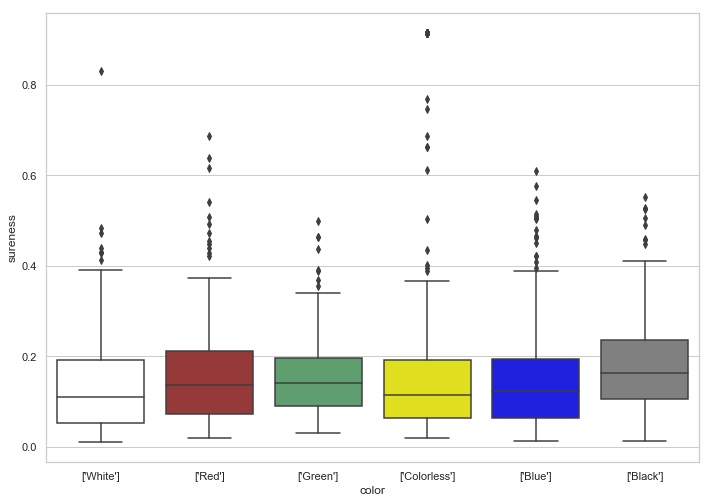

In [229]:
fig, ax = plt.subplots()
my_pal = {"['White']":'white' , "['Red']": 'brown', "['Green']":"g", "['Colorless']" : 'yellow', "['Blue']" : 'blue', "['Black']" : 'grey'}
sns.boxplot(x=data_df['color'], y=data_df['sureness'], palette=my_pal)
fig.set_size_inches(11.7, 8.27)

In [239]:
x_test_tfidf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [264]:
actual_vs_predict = pd.DataFrame(multnb.predict(x_test_tfidf), y_test)

In [266]:
actual_vs_predict.reset_index(inplace=True)

In [267]:
actual_vs_predict.head()

,colors,0
0,['Green'],['Red']
1,['Red'],['Colorless']
2,['Red'],['Colorless']
3,['Black'],['Red']
4,['Green'],['Green']


In [270]:
actual_vs_predict['predict'] = actual_vs_predict[0]

In [276]:
actual_vs_predict.drop(0,axis=1, inplace=True)

In [277]:
actual_vs_predict.head()

,colors,predict
0,['Green'],['Red']
1,['Red'],['Colorless']
2,['Red'],['Colorless']
3,['Black'],['Red']
4,['Green'],['Green']


In [278]:
actual_vs_predict['True_False'] = actual_vs_predict['colors'] == actual_vs_predict['predict']

In [279]:
actual_vs_predict.head()

,colors,predict,True_False
0,['Green'],['Red'],False
1,['Red'],['Colorless'],False
2,['Red'],['Colorless'],False
3,['Black'],['Red'],False
4,['Green'],['Green'],True


In [289]:
trues_df = actual_vs_predict.groupby('colors').sum()

In [287]:
test_cards_t_f = actual_vs_predict.groupby('colors').count()

In [294]:
df = trues_df.merge(test_cards_t_f, on=trues_df.index)

In [296]:
df['True'] = df['True_False']

In [297]:
df.head()

,key_0,True_False,predict,True
0,['Black'],20.0,27,20.0
1,['Blue'],25.0,36,25.0
2,['Colorless'],36.0,48,36.0
3,['Green'],19.0,41,19.0
4,['Red'],13.0,23,13.0


In [298]:
df.drop('True_False', axis=1, inplace=True)

In [299]:
df['Wrong'] = df['predict'] - df['True']

In [302]:
df['Percent_Right'] = df['True'] / df['predict']

In [303]:
df.head()

,key_0,predict,True,Wrong,Percent_Right
0,['Black'],27,20.0,7.0,0.740741
1,['Blue'],36,25.0,11.0,0.694444
2,['Colorless'],48,36.0,12.0,0.750000
3,['Green'],41,19.0,22.0,0.463415
4,['Red'],23,13.0,10.0,0.565217


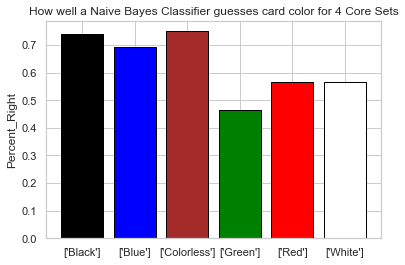

In [495]:
plt.bar(x=df['key_0'], height=df['Percent_Right'], color=['black','blue', 'brown','green','red','white'], edgecolor='black')
plt.ylabel('Percent_Right')
plt.title('How well a Naive Bayes Classifier guesses card color for 4 Core Sets')

plt.show;

In [310]:
multnb.

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [292]:
test_cards_t_f.drop('True_False', axis=1, inplace=True)

In [58]:
import seaborn as sns

In [112]:
from operator import itemgetter


card_color_max_sureness =[]
for x in range(0, len(color_sureness))
    card_color_max_sureness.append(max(color_sureness[0],key=itemgetter(1))[1])    #faster solution


In [113]:
card_color_max_sureness

[0.4488676484242548]

In [142]:
four_mtg_df['colors'].value_counts()


['Colorless']    212
['White']        173
['Red']          172
['Green']        171
['Blue']         170
['Black']        170
Name: colors, dtype: int64

In [126]:
color_count = []
for x in range(0, len(four_mtg_df['colors'].unique())):
    color_count.append(four_mtg_df['colors'].value_counts()[x])

In [127]:
color_count

[212, 173, 172, 171, 170, 170]

In [133]:
four_mtg_df['colors'].value_counts()

['Colorless']    212
['White']        173
['Red']          172
['Green']        171
['Blue']         170
['Black']        170
Name: colors, dtype: int64

In [134]:
colors = ["Colorless", 'White', 'Red', 'Green', 'Blue', 'Black']
color_count

[212, 173, 172, 171, 170, 170]

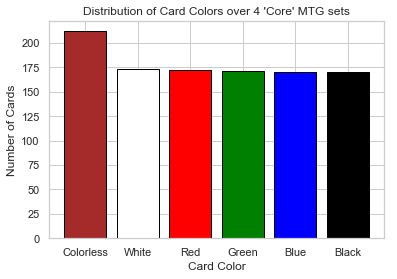

In [146]:
plt.bar(colors, color_count, color=['brown', 'white', 'red', 'green','blue', 'black'], edgecolor='black')
plt.xlabel("Card Color")
plt.ylabel("Number of Cards")
plt.title("Distribution of Card Colors over 4 'Core' MTG sets");

In [314]:
pd.DataFrame(x_test_tfidf.todense())

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.119207,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.123449,0.000000,0.0,0.0,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.183153,0.353917,0.0,0.0,0.0
6,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.089739,0.115606,0.0,0.0,0.0
7,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
8,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.085844,0.000000,0.0,0.0,0.0
9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [385]:
feat_weight_df[feat_weight_df['weight'] == 7.057954]

,weight,feature


In [459]:
feature_limited_df = feat_weight_df.query('weight < 7')

In [454]:
v.get_feature_names()

['10',
 '15',
 '200',
 '25',
 'abilities',
 'ability',
 'able',
 'activate',
 'activated',
 'add',
 'adder',
 'addition',
 'additional',
 'adds',
 'aegis',
 'aeronaut',
 'after',
 'agent',
 'agonies',
 'agonizing',
 'air',
 'ajani',
 'all',
 'alone',
 'also',
 'altac',
 'ambassador',
 'among',
 'amount',
 'amulet',
 'an',
 'ancestral',
 'ancestry',
 'ancient',
 'and',
 'angel',
 'angelic',
 'another',
 'anticipation',
 'any',
 'anything',
 'anywhere',
 'apprentice',
 'archangel',
 'arctic',
 'are',
 'aristocrat',
 'arms',
 'arsonist',
 'artifact',
 'artifacts',
 'artillery',
 'as',
 'ashes',
 'assistant',
 'at',
 'atemsis',
 'attach',
 'attached',
 'attack',
 'attacking',
 'attacks',
 'attended',
 'audacious',
 'augur',
 'aura',
 'auras',
 'available',
 'avarice',
 'avatar',
 'aven',
 'avenger',
 'awakened',
 'awakener',
 'axe',
 'back',
 'backwater',
 'bag',
 'ball',
 'bandit',
 'bane',
 'bank',
 'banshee',
 'bard',
 'barkhide',
 'barrens',
 'barrier',
 'base',
 'basic',
 'bat',
 'bat

In [415]:
keep = set(feature_limited_df['feature'])

In [473]:
keep

{'10',
 'abilities',
 'ability',
 'able',
 'activate',
 'activated',
 'add',
 'addition',
 'additional',
 'aeronaut',
 'ajani',
 'all',
 'alone',
 'also',
 'among',
 'amount',
 'an',
 'angel',
 'another',
 'any',
 'anything',
 'anywhere',
 'are',
 'artifact',
 'artifacts',
 'as',
 'at',
 'attach',
 'attached',
 'attack',
 'attacking',
 'attacks',
 'aura',
 'auras',
 'awakener',
 'base',
 'basic',
 'be',
 'beast',
 'become',
 'becomes',
 'been',
 'before',
 'begin',
 'beginning',
 'bird',
 'black',
 'block',
 'blocked',
 'blocking',
 'blocks',
 'blood',
 'blue',
 'bolt',
 'bond',
 'both',
 'bottom',
 'bow',
 'by',
 'came',
 'captain',
 'cards',
 'cast',
 'casting',
 'casts',
 'cat',
 'cause',
 'causes',
 'cavalier',
 'caves',
 'celestial',
 'chandra',
 'choice',
 'choose',
 'chooses',
 'chosen',
 'color',
 'colorless',
 'colors',
 'combat',
 'comes',
 'controller',
 'controls',
 'converted',
 'convoke',
 'copies',
 'copy',
 'cost',
 'costs',
 'could',
 'counter',
 'countered',
 'counter

In [464]:
keep_columns = [ind for ind, word in enumerate(v.get_feature_names()) if word in keep]

In [465]:
keep_columns

[0,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 15,
 21,
 22,
 23,
 24,
 27,
 28,
 30,
 35,
 37,
 39,
 40,
 41,
 45,
 49,
 50,
 52,
 55,
 57,
 58,
 59,
 60,
 61,
 65,
 66,
 73,
 87,
 88,
 93,
 94,
 95,
 96,
 97,
 99,
 100,
 101,
 105,
 106,
 111,
 112,
 113,
 114,
 115,
 122,
 125,
 126,
 131,
 132,
 134,
 142,
 144,
 146,
 148,
 151,
 152,
 154,
 155,
 158,
 159,
 160,
 161,
 162,
 166,
 170,
 171,
 172,
 173,
 182,
 183,
 184,
 186,
 189,
 194,
 195,
 196,
 198,
 199,
 200,
 203,
 204,
 205,
 206,
 207,
 208,
 211,
 213,
 236,
 237,
 240,
 241,
 243,
 244,
 248,
 249,
 252,
 253,
 254,
 255,
 257,
 259,
 261,
 262,
 264,
 266,
 267,
 270,
 271,
 272,
 275,
 277,
 279,
 280,
 281,
 286,
 288,
 292,
 293,
 295,
 296,
 298,
 301,
 303,
 305,
 306,
 307,
 308,
 313,
 314,
 318,
 319,
 320,
 321,
 323,
 327,
 328,
 329,
 330,
 331,
 334,
 335,
 336,
 343,
 346,
 349,
 350,
 352,
 354,
 356,
 357,
 358,
 359,
 367,
 369,
 372,
 373,
 376,
 379,
 380,
 382,
 383,
 384,
 385,
 386,
 388,
 390,
 391,


In [419]:
test_df = pd.DataFrame(x_test_tfidf.todense())

In [434]:
X_test_limited= test_df.iloc[:, keep_columns]

In [424]:
multNB = MultinomialNB()

In [466]:
multNB.fit(x_train_tfidf[:, keep_columns], y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [467]:
multNB.score(X_test_limited, y_test)

0.616822429906542